In [1]:
############# Libraries ##############

import pandas as pd
from bcb import sgs

from matplotlib import pyplot as plt
import numpy as np

# Evaluation metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape

epislon = 1e-20  # Define a small epsilon value for division by zero cases

def rmse(y_true, y_pred):
  return np.sqrt(mse(y_true, y_pred))

def mase(y_true, y_pred, y_baseline):
    # Calcula o MAE do modelo
    mae_pred = np.mean(np.abs(y_true - y_pred))
    # Calcula o MAE do modelo baseline Persistent Window (i.e., últimas h observações antes do teste)
    mae_naive = np.mean(np.abs(y_true - y_baseline))
    result = mae_pred/mae_naive
    return result

def pbe(y_true, y_pred):
  if np.sum(y_true)!=0:
    return 100*(np.sum(y_true - y_pred)/np.sum(y_true))
  else:
    return 100*(np.sum(y_true - y_pred)/(np.sum(y_true) + epislon))

def pocid(y_true, y_pred):
  n = len(y_true)
  D = [1 if (y_pred[i] - y_pred[i-1]) * (y_true[i] - y_true[i-1]) > 0 else 0 for i in range(1, n)]
  POCID = 100 * np.sum(D) / (n-1)
  return POCID

def mcpm(rmse_result, mape_result, pocid_result):
  er_result = 100 - pocid_result

  A1 = (rmse_result * mape_result * np.sin((2*np.pi)/3))/2
  A2 = (mape_result * er_result * np.sin((2*np.pi)/3))/2
  A3 = (er_result * rmse_result * np.sin((2*np.pi)/3))/2
  total = A1 + A2 + A3
  return total

def znorm(x):
  if np.std(x) != 0: 
      x_znorm = (x - np.mean(x)) / np.std(x)
  else:
      x_znorm = (x - np.mean(x)) / (np.std(x) + epislon)
  return x_znorm

def znorm_reverse(x, mean_x, std_x):
  x_denormalized = (np.array(x) * std_x) + mean_x
  return x_denormalized

def get_stats_norm(series, horizon, window):
  last_subsequence = series[-(horizon+window):-horizon].values
  last_mean = np.mean(last_subsequence)
  last_std = np.std(last_subsequence)
  return last_mean, last_std



# Para predição de vendas por UF (mensal), será considerado horizon = 12
# Para predição de vendas por município (anual), será considerado horizon = 1
def train_test_split(data, horizon):
  X = data.iloc[:,:-1] # features
  y = data.iloc[:,-1] # target

  X_train = X[:-horizon] # features train
  X_test =  X[-horizon:] # features test

  y_train = y[:-horizon] # target train
  y_test = y[-horizon:] # target test
  return X_train, X_test, y_train, y_test

def recursive_multistep_forecasting(X_test, model, horizon):
  # example é composto pelas últimas observações vistas
  # na prática, é o pbeprimeiro exemplo do conjunto de teste
  example = X_test.iloc[0].values.reshape(1,-1)

  preds = []
  for i in range(horizon):
    pred = model.predict(example)[0]
    preds.append(pred)

    # Descartar o valor da primeira posição do vetor de características
    example = example[:,1:]

    # Adicionar o valor predito na última posição do vetor de características
    example = np.append(example, pred)
    example = example.reshape(1,-1)
  return preds

def baseline_mean(series, horizon):
  # como as séries são normalizadas, esse baseline irá retornar uma reta próxima de zero
  pred = np.repeat(np.mean(znorm(series[:-horizon])), horizon)
  return pred

def baseline_persistent(series, horizon):
  return np.repeat(znorm(series[-2*horizon:-horizon]).values[-1], horizon)

def baseline_persistent_window(series, horizon):
  subsequence = znorm(series[-horizon*2:-horizon]).values
  return subsequence

def baseline_persistent_window2(series, horizon):
  subsequence2 = series[-horizon*2:-horizon].values
  return subsequence2

# Em geral, considera-se um tamanho de janela capaz de capturar um ciclo dos dados
# Por exemplo, 12 observações no caso dos dados com frequência mensal
def rolling_window(series, window):
  data = []
  for i in range(len(series)-window):
    example = znorm(np.array(series[i:i+window+1]))
    data.append(example)
  df = pd.DataFrame(data)
  return df

def rolling_window_prophet(series, window):
  data = []
  for i in range(len(series)-window):
    # example = znorm(np.array(series[i:i+window+1]))
    example = (np.array(series[i:i+window+1]))
    data.append(example)
  df = pd.DataFrame(data)
  return df

In [2]:
############# Loading ##############

import os
import csv

def extract_estado(file_name):
    parts = file_name.split('_')
    estado = parts[1]
    return estado

def read_csv_files(folder_path):
    estados = []
    files = os.listdir(folder_path)
    for file_name in files:
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r', newline='') as csvfile:
                reader = csv.reader(csvfile)
                headers = next(reader)
                estado = extract_estado(file_name)
                estados.append(estado)
                estados.sort()
    return estados



In [5]:
########### BCB codes #############

state_codes = {
    'ac': [12569, 12597, 13144, 13151, 14002, 14029, 14056, 15861, 15893, 15925],
    'al': [12745, 13343, 13348, 13353, 14003, 14030, 14057, 15862, 15894, 15926],
    'am': [25411, 25412, 12572, 12598, 13146, 13153, 14005, 14032, 14059, 15864, 15896, 15928],
    'ap': [12570, 12596, 13145, 13152, 14004, 14031, 14058, 15863, 15895, 15927],
    'ba': [21944, 21945, 25415, 25416, 12991, 13137, 13138, 13139, 14006, 14033, 14060, 15865, 15897, 15929],
    'ce': [21959, 21960, 25390, 25391, 13010, 13093, 13094, 13166, 14007, 14034, 14061, 15866, 15898, 15930],
    'df': [13069, 13071, 13072, 14008, 14035, 14062, 15867, 15899, 15931, 21988],
    'es': [21926, 21928, 25398, 25399, 12985, 13386, 13387, 13388, 14009, 14036, 14063, 15868, 15900, 15932],
    'go': [21937, 21941, 25383, 25384, 13030, 13031, 13061, 14010, 14037, 14064, 15869, 15901, 15933, 21987],
    'ma': [13011, 13244, 13245, 13247, 14011, 14038, 14065, 15870, 15902, 15934],
    'mg': [21936, 21940, 25379, 25380, 10746, 13026, 13028, 13029, 14014, 14041, 14068, 15873, 15905, 15937, 21986],
    'ms': [13065, 13067, 13068, 14013, 14040, 14067, 15872, 15904, 15936, 21990],
    'mt': [21938, 13062, 13063, 13064, 14012, 14039, 14066, 15871, 15903, 15935, 21989],
    'pa': [25409, 25410, 12573, 12599, 13147, 13154, 14015, 14042, 14069, 11075],
    'pb': [12743, 13342, 13347, 13352, 14016, 14043, 14070, 15875, 15907, 15939],
    'pe': [25417, 25418, 12742, 13341, 13346, 13351, 14018, 14045, 14072, 15877, 15909, 15941],
    'pi': [13012, 13167, 13168, 13169, 14019, 14046, 14073, 15878, 15910, 15942],
    'pr': [21979, 21980, 25408, 25413, 12619, 13073, 13074, 13075, 14017, 14044, 14071, 15876, 15908, 15940],
    'rj': [25396, 25397, 21927, 21929, 14020, 14047, 14074, 15879, 15911, 15943],
    'rn': [12744, 13344, 13349, 13354, 14021, 14048, 14075, 15880, 15912, 15944],
    'ro': [12574, 12600, 13148, 13155, 14023, 14050, 14077, 15882, 15914, 15946],
    'rr': [12576, 12601, 13149, 13156, 14024, 14051, 14078, 15883, 15915, 15947],
    'rs': [21932, 21933, 25401, 25404, 10753, 12553, 13078, 13079, 13080, 14022, 14049, 14076, 15881, 15913, 15945],
    'sc': [21981, 21982, 25402, 25405, 12625, 13081, 13082, 13083, 14025, 14052, 14079, 15884, 15916, 15948],
    'se': [12746, 13345, 13350, 13356, 14027, 14054, 14081, 15886, 15918, 15950],
    'sp': [21925, 25392, 25394, 12867, 13021, 13022, 13023, 13024, 13025, 14026, 14053, 14080, 15885, 15917, 15949, 7493, 10755, 193],
    'to': [12577, 12602, 13150, 13157, 14028, 14055, 14082, 15887, 15919, 15951]
}


C:\Users\jonas\AppData\Local\Temp\ipykernel_15356\2511638925.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.rename(columns={'DATA': 'ds'}, inplace=True)
C:\Users\jonas\AppData\Local\Temp\ipykernel_15356\2511638925.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ds'] = pd.to_datetime(filtered_df['ds'])


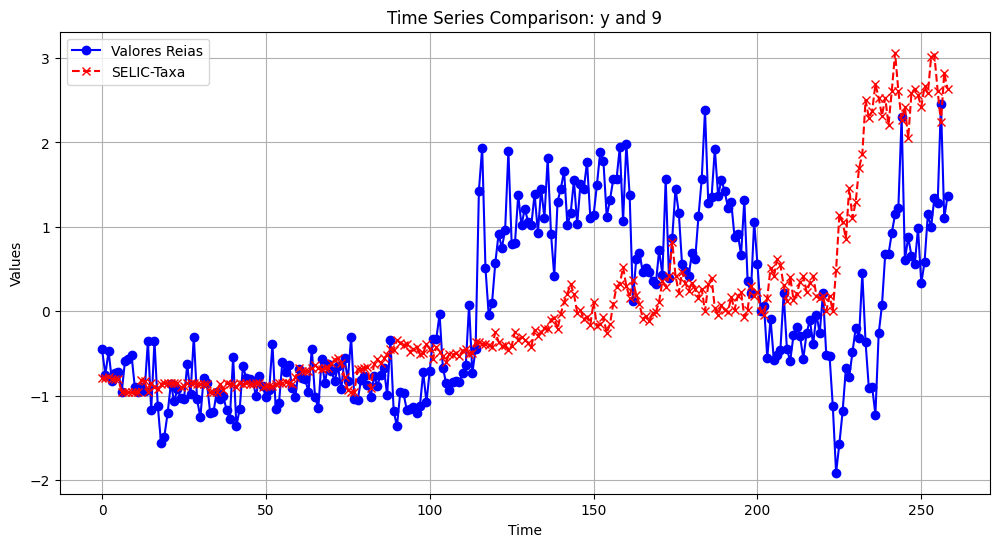

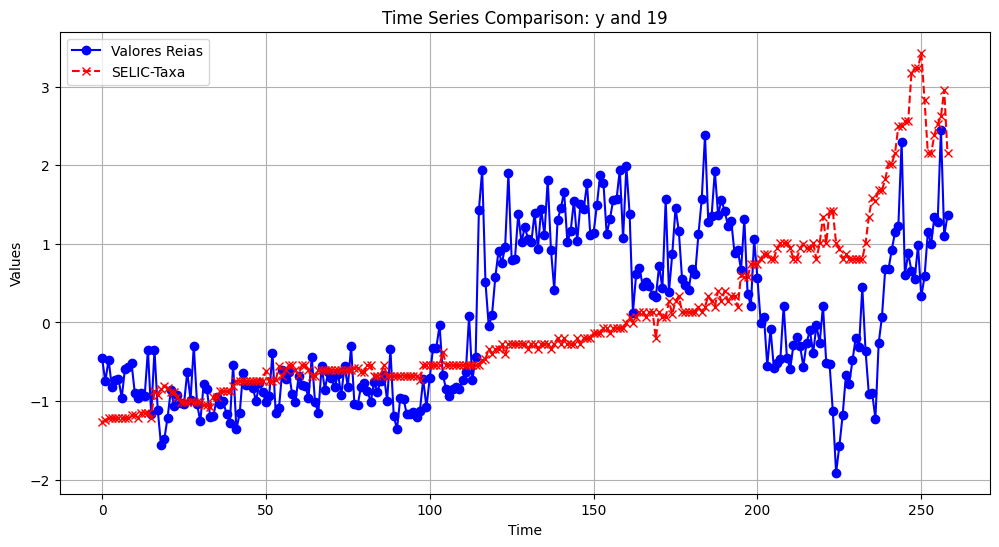

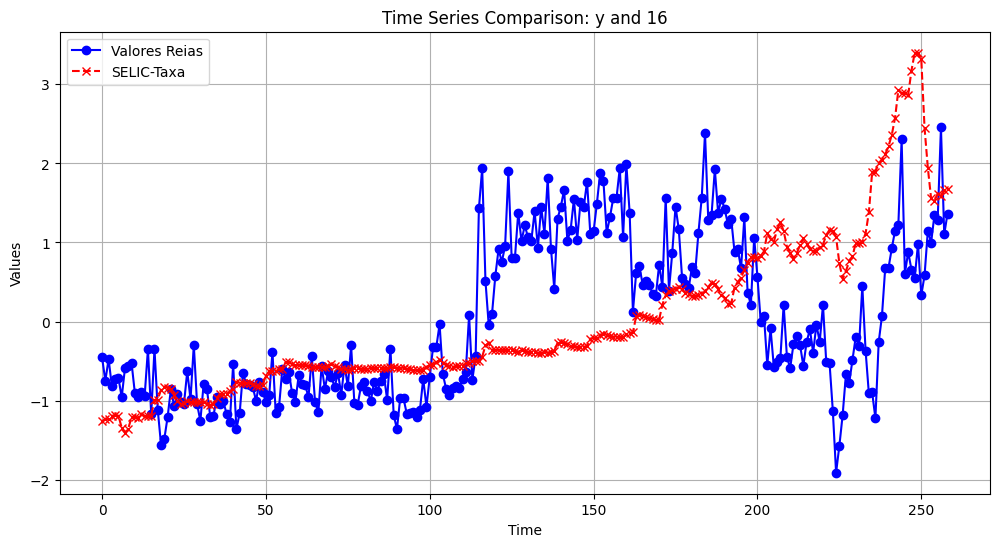

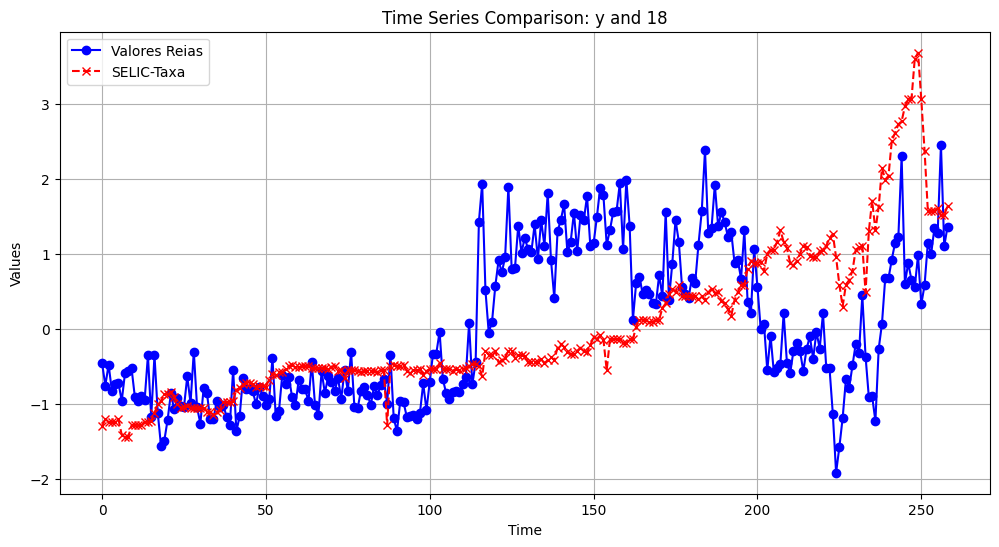

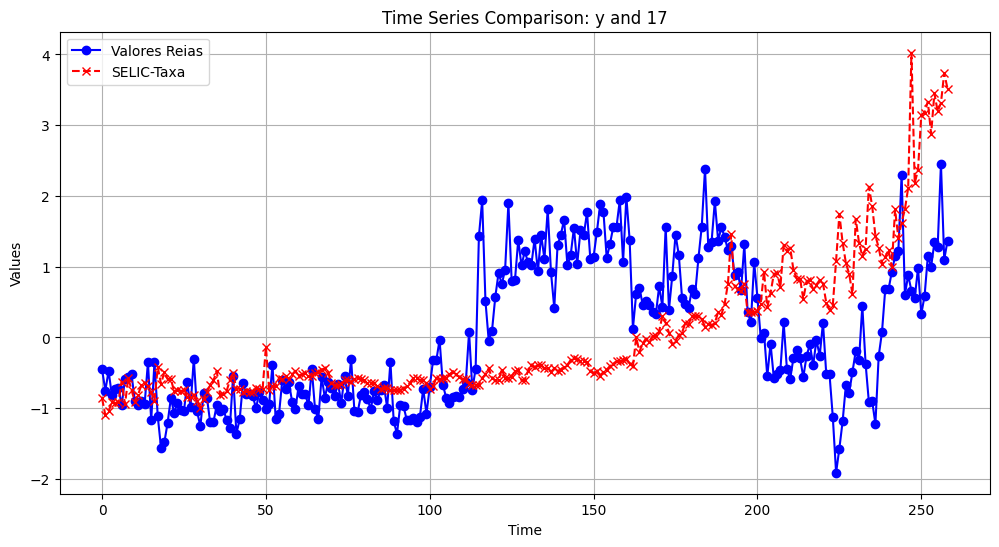

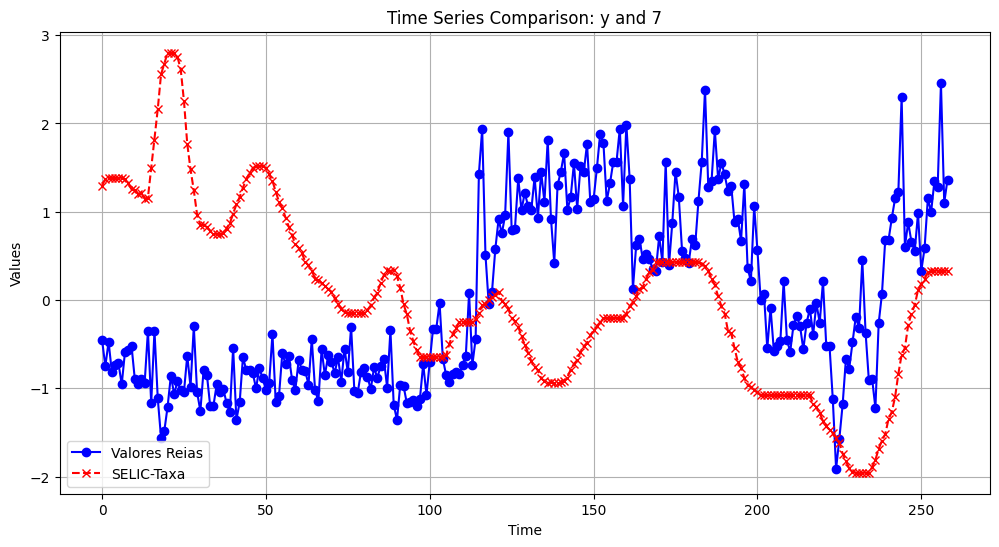

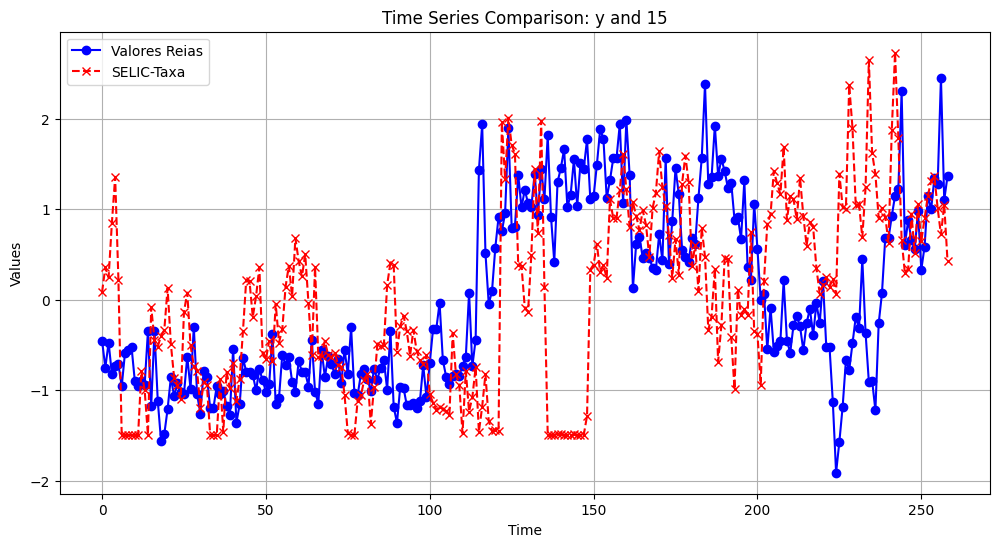

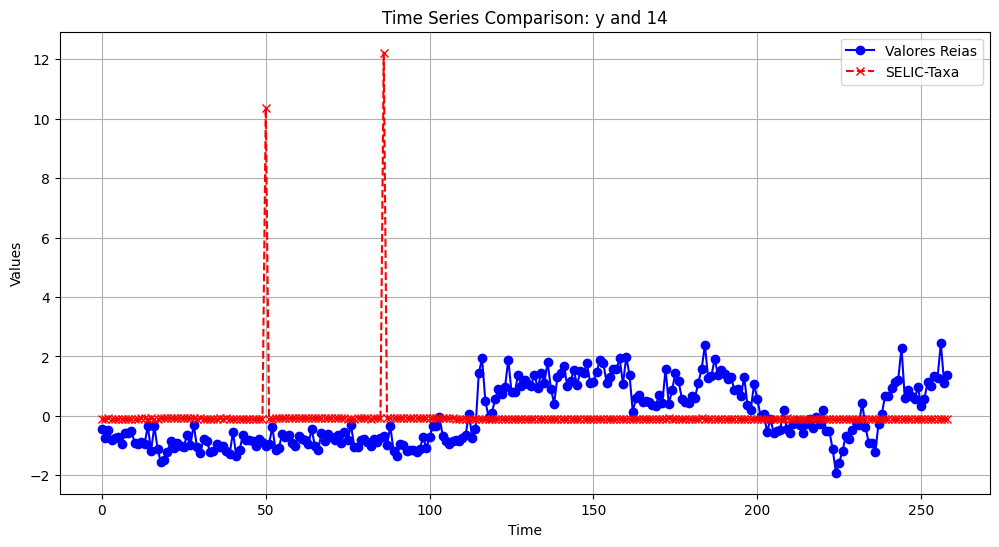

In [9]:
########### CORR TEST ##################

product = 'gasolinac'
estado = 'sp'

import os

horizon = 12
window = 12

# products = sorted([name for name in os.listdir('../uf/') if os.path.isdir(os.path.join('../uf/', name))])
products = ['etanolhidratado', 'gasolinac', 'glp', 'oleodiesel']

# Initialize a dictionary to store column counts
column_counts = {}

############################# Coleta de dados externos do BCB ##########################################  *** CHECK NORMALIZATION!!!
dfext = pd.read_csv(f"./01-EXT-PrecoANP.csv", header=0, sep=",")
dfext = pd.DataFrame(dfext)
dfext.iloc[:, 0] = pd.to_datetime(dfext.iloc[:, 0], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')
########################################################################################################

# print(estados)

# for product in products:
#     folder_path = f'./uf/{product}/'
#     estados = read_csv_files(folder_path)
#     for estado in estados:


############################# Coleta de dados externos do BCB ########################################## 
all_extdata = []
# for code in state_codes[estado]:
#     try:
#         bcb_data = sgs.get({'series_id': code})
#         if isinstance(bcb_data, pd.DataFrame):
#             all_extdata.append(bcb_data)
#         else:
#             print(f"Received data for series ID {code} is not a DataFrame.")
#     except Exception as e:
#         print(f"An error occurred while fetching data for series ID {code}: {e}")
########################################################################################################


filtered_df = dfext[dfext['PRODUTO'] == product]
filtered_df2 = filtered_df[filtered_df['ESTADO'] == estado]

df = pd.read_csv(f"./uf/{product}/mensal_{estado}_{product}.csv", header=0, sep=";")
df = pd.DataFrame(df)

df['timestamp'] = pd.to_datetime(df['timestamp'].astype(str), format='%Y%m')

series = df["m3"]
# series = rolling_window(df["m3"],window)
# series = series.iloc[:,-1]
series.index = range(0, len(series))

monthly_data = df.groupby(df['timestamp'].dt.to_period('M'))['m3'].sum().reset_index()
monthly_data['timestamp'] = monthly_data['timestamp'].dt.to_timestamp()

##################################################################################

monthly_data.rename(columns={'m3': 'y'}, inplace=True)

monthly_data_norm_minuswind = rolling_window(monthly_data['y'], window)


# ##################################################################################

X_train, X_test, y_train, y_test = train_test_split(monthly_data_norm_minuswind, horizon)

first_column = monthly_data.iloc[:, 0] 
first_column = first_column[window:-(horizon)]
first_column = first_column.reset_index(drop=True)

prophet_data = pd.concat([first_column], axis=1)       
prophet_data2 = pd.concat([prophet_data, y_train], axis=1)
# Opção adicionando os dados (X_train)
# prophet_data2 = pd.concat([prophet_data, X_train, y_train], axis=1)

prophet_data2.rename(columns={window: 'y'}, inplace=True)
prophet_data2.rename(columns={'timestamp': 'ds'}, inplace=True)


# ##############################################################

### Filtro por produto e estado
filtered_df = dfext[(dfext['PRODUTO'] == product) & (dfext['ESTADO'] == estado)]
filtered_df.rename(columns={'DATA': 'ds'}, inplace=True)
filtered_df['ds'] = pd.to_datetime(filtered_df['ds'])
prophet_data2['ds'] = pd.to_datetime(prophet_data2['ds'])
merged_df = pd.merge(filtered_df, prophet_data2, on='ds', how='inner')
merged_df = merged_df.drop(columns=['PRODUTO', 'ESTADO'])

######################################################################


numb_extdata = len(all_extdata)
# for i in range(numb_extdata):
#     df = all_extdata[i]
#     df_filtered = df[df.index <= '2024-02-01']
#     df2 = pd.DataFrame(list(df_filtered['series_id'].items()), columns=['ds', f'{i}'])
#     prophet_data2 = pd.merge(prophet_data2, df2[['ds', f'{i}']], left_on='ds', right_on='ds', how='left')
# prophet_data2 = prophet_data2.fillna(0)
prophet_data2.dropna(inplace=True)
temp_y = merged_df['y']
merged_df = merged_df.drop('y', axis=1)
merged_result = pd.merge(merged_df, prophet_data2, on='ds')
new_column_names = ['ds'] + [f'{i}' for i in range(1, len(merged_result.columns))]
merged_result.columns = new_column_names

Y_brut = series.tail(len(merged_df)+horizon)
Y_brut2 = Y_brut.head(len(merged_df)).reset_index(drop=True)
merged_result['y'] = Y_brut2
merged_result.drop(merged_result.columns[22], axis=1, inplace=True)

#### CHECK CORRELATION ###############################################

columns_ext = merged_result.columns[2:-1]

dataE = pd.DataFrame({f'{i+1}': merged_result[col] for i, col in enumerate(columns_ext)})

dataE['y'] = merged_result['y']

dataE

# Opção normalizando antes da CORRELACAO
# dataE = dataE.apply(znorm, axis=0)

pearson_corr = dataE.corr(method='pearson')
spearman_corr = dataE.corr(method='spearman')
kendall_corr = dataE.corr(method='kendall')

correlation_with_y = pd.DataFrame({
    'Pearson': pearson_corr['y'].drop('y'),
    'Spearman': spearman_corr['y'].drop('y'),
    'Kendall': kendall_corr['y'].drop('y')
})

correlation_with_y['Pearson2'] = correlation_with_y['Pearson'].abs()
correlation_with_y['Spearman2'] = correlation_with_y['Spearman'].abs()
correlation_with_y['Kendall2'] = correlation_with_y['Kendall'].abs()
correlation_with_y['total'] = correlation_with_y['Pearson2'] + correlation_with_y['Spearman2'] + correlation_with_y['Kendall2']
DataTBI = correlation_with_y['total'][(correlation_with_y['Pearson2'] > 0.3) | (correlation_with_y['Spearman2'] > 0.3) | (correlation_with_y['Kendall2'] > 0.3)]
DataTBI_sorted = DataTBI.sort_values(ascending=False)
DataTBI_SelCol = dataE.loc[:, DataTBI_sorted.index]
DataTBI_SelCol.insert(0, 'ds', merged_result['ds'].values)

DataTBI_SelCol['y'] = dataE['y']
# DataTBI_SelCol_norm = DataTBI_SelCol
DataTBI_SelCol_norm = DataTBI_SelCol.apply(znorm, axis=0)

import matplotlib.pyplot as plt

# Exclude the columns 'ds' and 'y' from the plotting
columns_to_plot = [col for col in DataTBI_SelCol_norm.columns if col not in ['y', 'ds']]

# Plot time series for 'y' and each other column
for column in columns_to_plot:
    plt.figure(figsize=(12, 6))
    
    # Plot 'y' column
    plt.plot(DataTBI_SelCol_norm.index, DataTBI_SelCol_norm['y'], label='Valores Reias', color='blue', linestyle='-', marker='o')
    
    # Plot current column
    plt.plot(DataTBI_SelCol_norm.index, DataTBI_SelCol_norm[column], label='SELIC-Taxa', color='red', linestyle='--', marker='x')
    
    plt.title(f'Time Series Comparison: y and {column}')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()



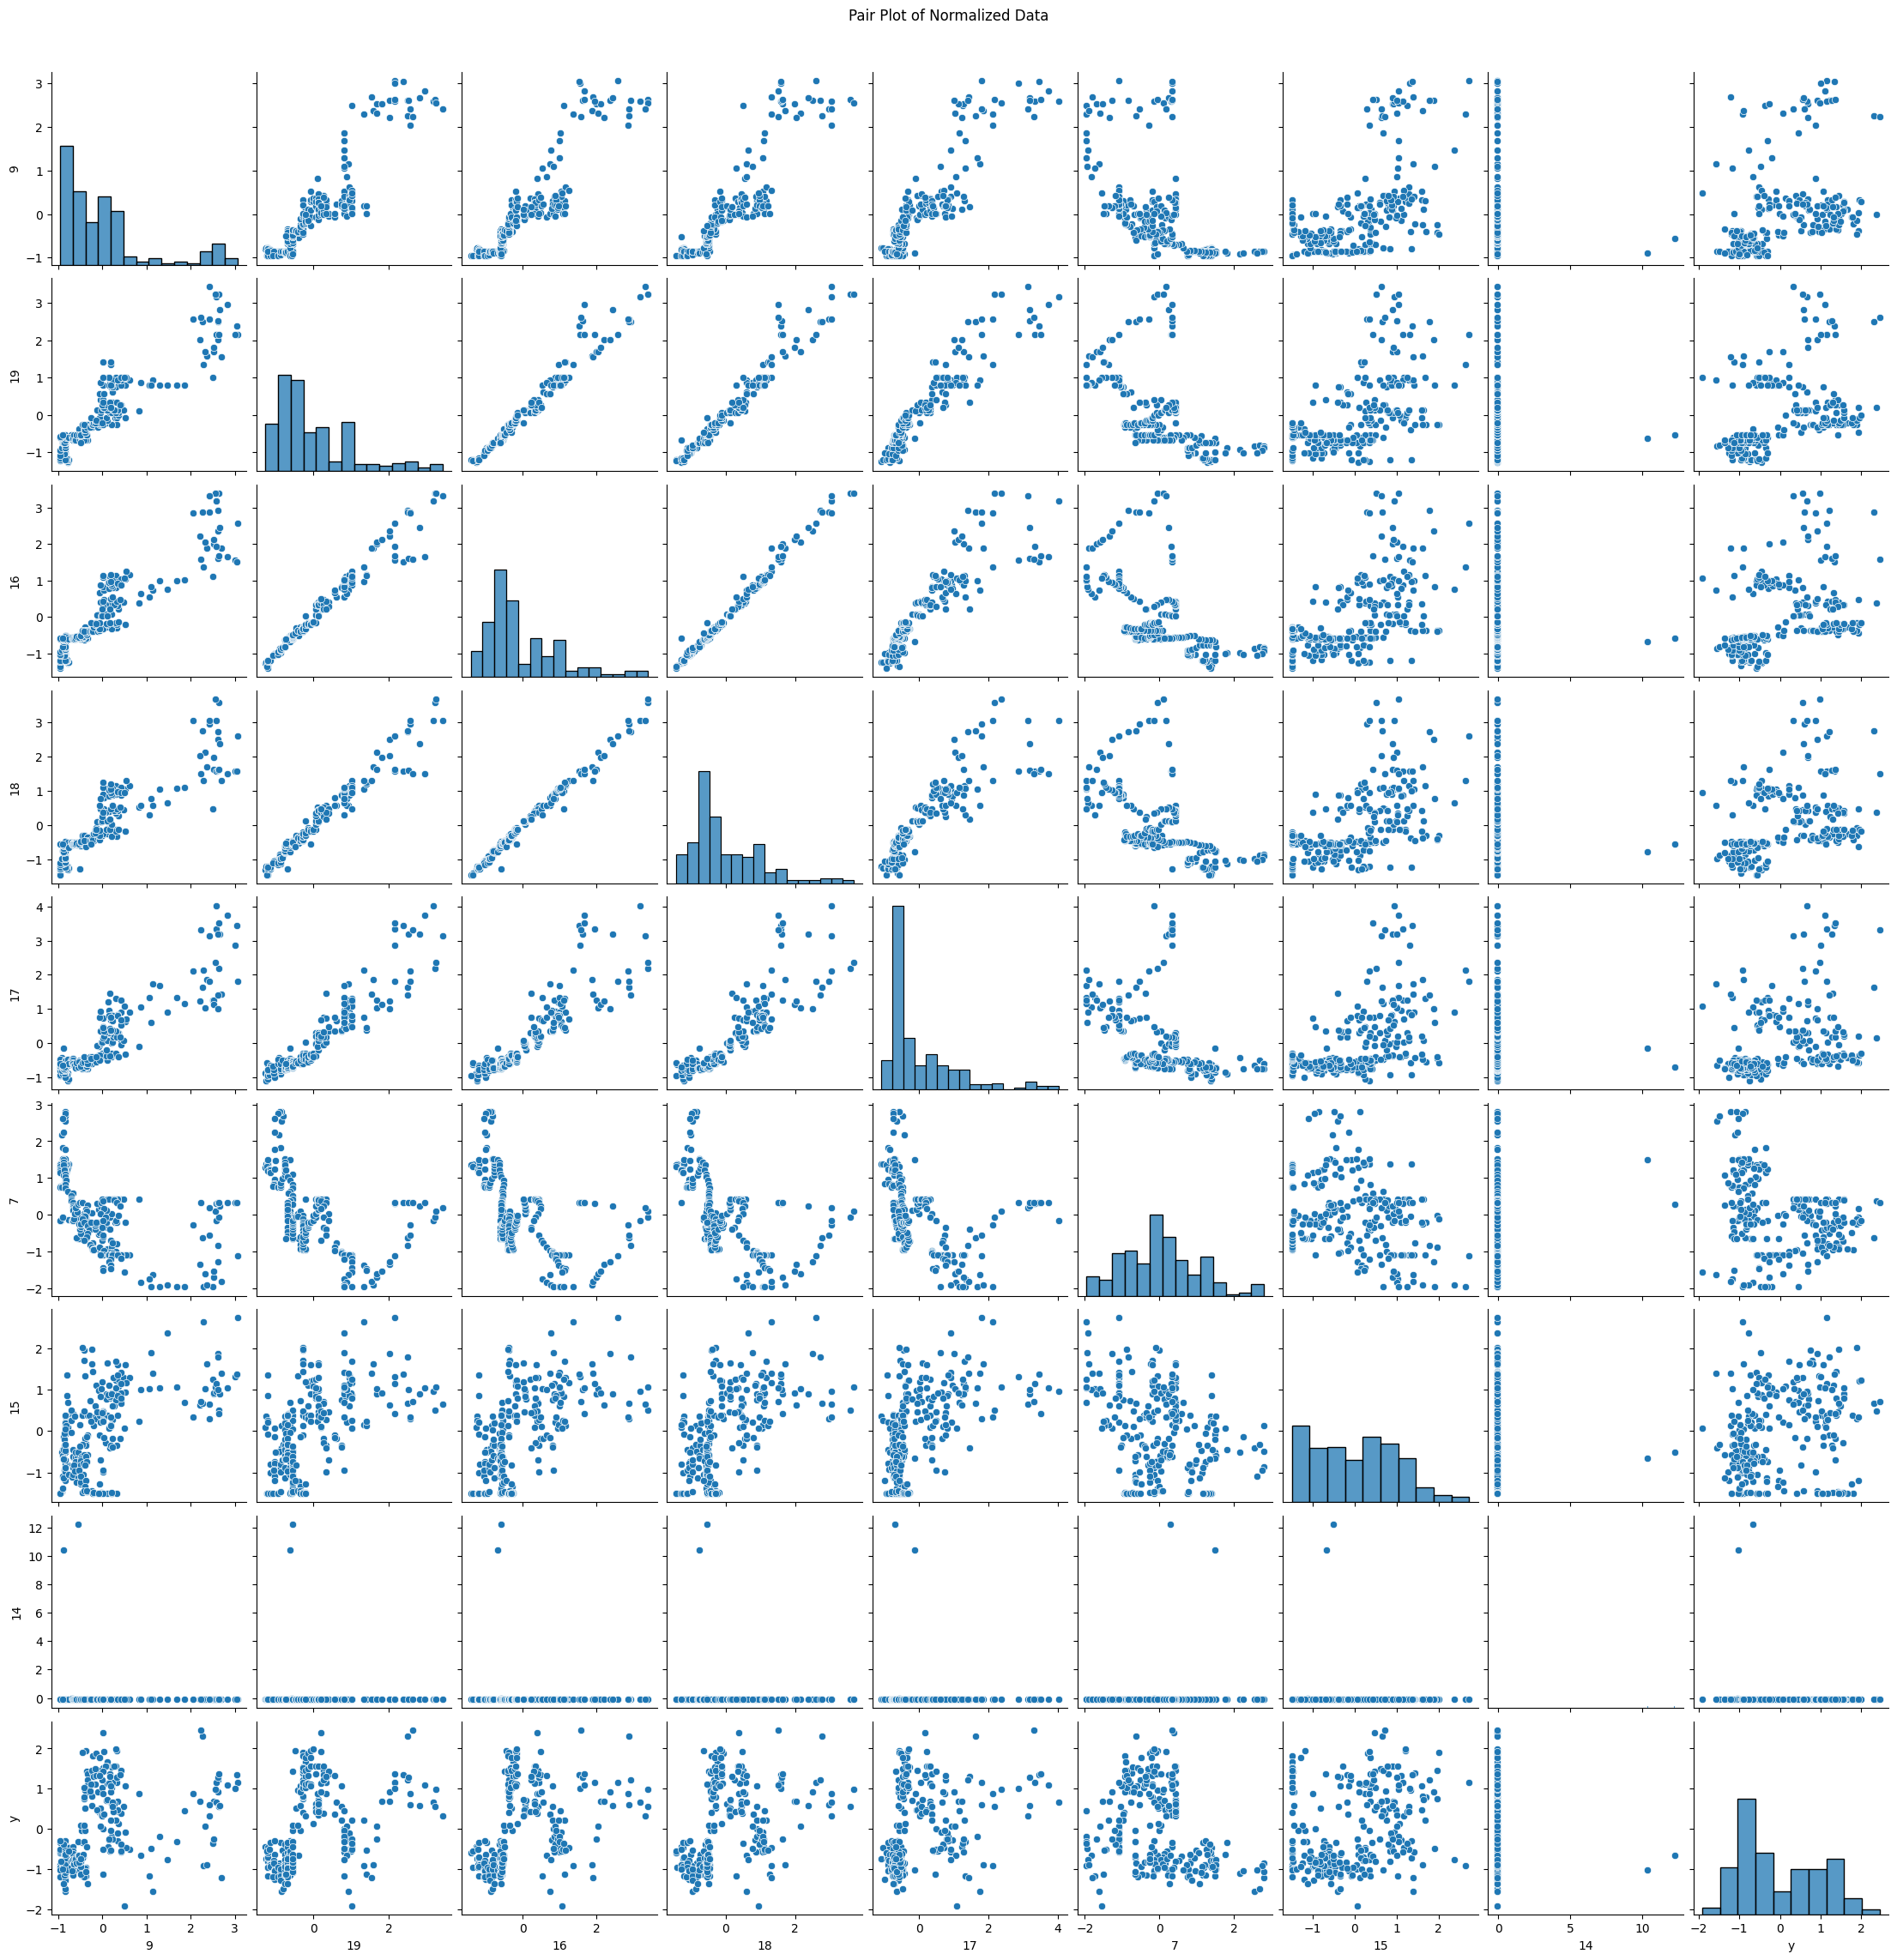

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

DataTBI_SelCol_norm2 = DataTBI_SelCol_norm.drop(columns='ds')
sns.pairplot(DataTBI_SelCol_norm2)
plt.suptitle('Pair Plot of Normalized Data', y=1.02)
plt.show()

In [24]:
########### CORR AUTO ##################

import os

horizon = 12
window = 12

# products = sorted([name for name in os.listdir('../uf/') if os.path.isdir(os.path.join('../uf/', name))])
products = ['etanolhidratado', 'gasolinac', 'glp', 'oleodiesel']

# Initialize a dictionary to store column counts
column_counts = {}

############################# Coleta de dados externos do BCB ##########################################  *** CHECK NORMALIZATION!!!
dfext = pd.read_csv(f"./01-EXT-PrecoANP.csv", header=0, sep=",")
dfext = pd.DataFrame(dfext)
dfext.iloc[:, 0] = pd.to_datetime(dfext.iloc[:, 0], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')
########################################################################################################

# print(estados)

for product in products:
    folder_path = f'./uf/{product}/'
    estados = read_csv_files(folder_path)
    for estado in estados:


        ############################# Coleta de dados externos do BCB ########################################## 
        all_extdata = []
        # for code in state_codes[estado]:
        #     try:
        #         bcb_data = sgs.get({'series_id': code})
        #         if isinstance(bcb_data, pd.DataFrame):
        #             all_extdata.append(bcb_data)
        #         else:
        #             print(f"Received data for series ID {code} is not a DataFrame.")
        #     except Exception as e:
        #         print(f"An error occurred while fetching data for series ID {code}: {e}")
        ########################################################################################################


        filtered_df = dfext[dfext['PRODUTO'] == product]
        filtered_df2 = filtered_df[filtered_df['ESTADO'] == estado]

        df = pd.read_csv(f"./uf/{product}/mensal_{estado}_{product}.csv", header=0, sep=";")
        df = pd.DataFrame(df)

        df['timestamp'] = pd.to_datetime(df['timestamp'].astype(str), format='%Y%m')

        series = df["m3"]
        # series = rolling_window(df["m3"],window)
        # series = series.iloc[:,-1]
        series.index = range(0, len(series))

        monthly_data = df.groupby(df['timestamp'].dt.to_period('M'))['m3'].sum().reset_index()
        monthly_data['timestamp'] = monthly_data['timestamp'].dt.to_timestamp()

        ##################################################################################

        monthly_data.rename(columns={'m3': 'y'}, inplace=True)

        monthly_data_norm_minuswind = rolling_window(monthly_data['y'], window)


        # ##################################################################################

        X_train, X_test, y_train, y_test = train_test_split(monthly_data_norm_minuswind, horizon)

        first_column = monthly_data.iloc[:, 0] 
        first_column = first_column[window:-(horizon)]
        first_column = first_column.reset_index(drop=True)

        prophet_data = pd.concat([first_column], axis=1)       
        prophet_data2 = pd.concat([prophet_data, y_train], axis=1)
        # Opção adicionando os dados brutos (X_train)
        # prophet_data2 = pd.concat([prophet_data, X_train, y_train], axis=1)

        prophet_data2.rename(columns={window: 'y'}, inplace=True)
        prophet_data2.rename(columns={'timestamp': 'ds'}, inplace=True)


        # ##############################################################

        ### Filtro por produto e estado
        filtered_df = dfext[(dfext['PRODUTO'] == product) & (dfext['ESTADO'] == estado)]
        filtered_df.rename(columns={'DATA': 'ds'}, inplace=True)
        filtered_df['ds'] = pd.to_datetime(filtered_df['ds'])
        prophet_data2['ds'] = pd.to_datetime(prophet_data2['ds'])
        merged_df = pd.merge(filtered_df, prophet_data2, on='ds', how='inner')
        merged_df = merged_df.drop(columns=['PRODUTO', 'ESTADO'])

        ######################################################################


        numb_extdata = len(all_extdata)
        # for i in range(numb_extdata):
        #     df = all_extdata[i]
        #     df_filtered = df[df.index <= '2024-02-01']
        #     df2 = pd.DataFrame(list(df_filtered['series_id'].items()), columns=['ds', f'{i}'])
        #     prophet_data2 = pd.merge(prophet_data2, df2[['ds', f'{i}']], left_on='ds', right_on='ds', how='left')
        # prophet_data2 = prophet_data2.fillna(0)
        prophet_data2.dropna(inplace=True)
        temp_y = merged_df['y']
        merged_df = merged_df.drop('y', axis=1)
        merged_result = pd.merge(merged_df, prophet_data2, on='ds')
        new_column_names = ['ds'] + [f'{i}' for i in range(1, len(merged_result.columns))]
        merged_result.columns = new_column_names

        Y_brut = series.tail(259+12)
        Y_brut2 = Y_brut.head(259).reset_index(drop=True)
        merged_result['y'] = Y_brut2
        merged_result.drop(merged_result.columns[22], axis=1, inplace=True)

        #### CHECK CORRELATION ###############################################

        columns_ext = merged_result.columns[2:-1]

        dataE = pd.DataFrame({f'{i+1}': merged_result[col] for i, col in enumerate(columns_ext)})

        dataE['y'] = merged_result['y']

        pearson_corr = dataE.corr(method='pearson')
        spearman_corr = dataE.corr(method='spearman')
        kendall_corr = dataE.corr(method='kendall')

        correlation_with_y = pd.DataFrame({
            'Pearson': pearson_corr['y'].drop('y'),
            'Spearman': spearman_corr['y'].drop('y'),
            'Kendall': kendall_corr['y'].drop('y')
        })

        correlation_with_y['Pearson2'] = correlation_with_y['Pearson'].abs()
        correlation_with_y['Spearman2'] = correlation_with_y['Spearman'].abs()
        correlation_with_y['Kendall2'] = correlation_with_y['Kendall'].abs()
        correlation_with_y['total'] = correlation_with_y['Pearson2'] + correlation_with_y['Spearman2'] + correlation_with_y['Kendall2']
        DataTBI = correlation_with_y['total'][(correlation_with_y['Pearson2'] > 0.3) | (correlation_with_y['Spearman2'] > 0.3) | (correlation_with_y['Kendall2'] > 0.3)]
        DataTBI_sorted = DataTBI.sort_values(ascending=False)
        DataTBI_SelCol = dataE.loc[:, DataTBI_sorted.index]
        DataTBI_SelCol.insert(0, 'ds', merged_result['ds'].values)

        DataTBI_SelCol['y'] = dataE['y']

        ## Contagem de colunas
        for column in DataTBI_SelCol.columns:
            if column in column_counts:
                column_counts[column] += 1
            else:
                column_counts[column] = 1


C:\Users\jonas\AppData\Local\Temp\ipykernel_13068\879772058.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.rename(columns={'DATA': 'ds'}, inplace=True)
C:\Users\jonas\AppData\Local\Temp\ipykernel_13068\879772058.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ds'] = pd.to_datetime(filtered_df['ds'])
C:\Users\jonas\AppData\Local\Temp\ipykernel_13068\879772058.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [25]:
#### Subtotal de colunas (Dados Externos) ####

numeric_columns = []
non_numeric_columns = []

for column in column_counts:
    try:
        int(column)
        numeric_columns.append(column)
    except ValueError:
        non_numeric_columns.append(column)


numeric_columns.sort(key=int)
non_numeric_columns.sort()
sorted_columns = numeric_columns + non_numeric_columns
sorted_column_counts = {col: column_counts[col] for col in sorted_columns}

# # Print the sorted columns with their counts
# for column, count in sorted_column_counts.items():
#     print(f"Column '{column}' appears {count} time(s).")


sorted_column_counts = dict(sorted(column_counts.items(), key=lambda x: (-x[1], x[0])))
sorted_column_counts.pop('ds', None)
sorted_column_counts.pop('y', None)


for column, count in sorted_column_counts.items(): print(f"Coluna '{column}' aparece {count} vezes.")


Coluna '18' aparece 99 vezes.
Coluna '16' aparece 98 vezes.
Coluna '19' aparece 98 vezes.
Coluna '9' aparece 98 vezes.
Coluna '7' aparece 94 vezes.
Coluna '15' aparece 83 vezes.
Coluna '17' aparece 83 vezes.
Coluna '11' aparece 80 vezes.
Coluna '12' aparece 80 vezes.
Coluna '13' aparece 80 vezes.
Coluna '5' aparece 80 vezes.
Coluna '14' aparece 79 vezes.
Coluna '6' aparece 78 vezes.
Coluna '1' aparece 75 vezes.
Coluna '2' aparece 75 vezes.
Coluna '20' aparece 49 vezes.
Coluna '4' aparece 20 vezes.
Coluna '10' aparece 11 vezes.
Coluna '3' aparece 4 vezes.
